# Packages

In [1]:
import os

In [2]:
os.chdir('..')
%pwd

'C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import  transforms, utils
import random
import time
import os
import copy
import glob
import numpy as np
from models.bisenet import BiSeNet
from dataset import Dataset_SMP, get_preprocessing, get_training_augmentation, split_data
from display import display_result, display_proba
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import segmentation_models_pytorch as smp

# Fix seed

In [4]:
torch.backends.cudnn.deterministic = True
random.seed(123456)
torch.manual_seed(123456)
torch.cuda.manual_seed(123456)
np.random.seed(123456)

# Parameters

In [5]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
data_root = "C:\\Users\\gueganj\\Desktop\\My_DataBase\\nature\\"
# Models
model_name = "unet"
# encoder
encoder = "mobilenet_v2"
# Number of classes in the dataset
num_classes = 1
# Batch size for training (change depending on how much memory you have)
batch_size = 8
# Learning rate
lr = 0.1
# Momentum
momentum = 0.99
# Weight decay
weight_decay = 0.0001
# algorithm use for optimization
algo_optim = 'SGD'
# Number of epochs to train for 
num_epochs = 200
# prediction threshold
threshold = 0.25
# size of image in input
input_size = 448
# total number of image used
size_dataset = 33
# Flag for feature extracting. When False, we finetune the whole model, when True we only update the reshaped layer params
feature_extract = False
# Flag for using Tensorboard tool
use_tensorboard = True
# Flag for using data augmentation
use_augmentation = True
# Flag for using a learning rate scheduler
lr_scheduler = "constant"
# Load checkpoint
load_checkpoint = False #"C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection\\checkpoint_logs\\27_10_2020-11_50.ckpt"
# Landmarks directory
landmarks_dir = False # os.path.join(data_root,"landmarks","face_landmarks.csv")

In [6]:
# create a config dictionnary
config = {}
for item in dir().copy():
    if (not item.startswith('_')) and (item!='In') and (item!='Out') and item != 'config' and item != 'item':
        if str(type(eval(item)))[8:-2] in ['str','bool','int','float']:
            config[item] = eval(item)

In [7]:
if num_classes == 1:
    activation = 'sigmoid'
else:
    activation = 'softmax'

# Device

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model

In [9]:
# Initialize and Reshape the Networks
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


if model_name == "bisenet":
    # Load
    model = BiSeNet(n_classes=19) # trained on 19 classes
    # change final layer to tune and output only 2 classes
    set_parameter_requires_grad(model, feature_extract)
    model.conv_out.conv_out   = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #model.conv_out16.conv_out = nn.Conv2d(64, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)
    #model.conv_out32.conv_out = nn.Conv2d(64, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)
    if landmarks_dir:
        model.cp.resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

elif model_name == "unet":
    model = smp.Unet(encoder_name=encoder,  encoder_weights='imagenet', activation=activation)
    model.segmentation_head[0] = nn.Conv2d(16, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)
    if landmarks_dir:
        model.encoder.features[0][0] = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

elif model_name == "DeepLabV3Plus":
    model = smp.DeepLabV3Plus(encoder_name=encoder,  encoder_weights='imagenet', activation=activation)
    model.segmentation_head[0] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')
model.to(device)

print('{:,} parameters to learn'.format(sum(p.numel() for p in model.parameters())))

6,628,816 parameters to learn


In [37]:
model = smp.DeepLabV3Plus(encoder_name='timm-efficientnet-b0',  encoder_weights='imagenet', activation=activation)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to C:\Users\gueganj/.cache\torch\hub\checkpoints\tf_efficientnet_b0_aa-827b6e33.pth


In [39]:
model.segmentation_head[0]

Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Data

In [10]:
# data split
image_extension = '.jpg'
mask_extension  = '.png'
train_set, valid_set, test_set = split_data(data_root, "images", image_extension, "masks\\frame", mask_extension, size_dataset, use_id=False)
train_image, train_mask = train_set
valid_image, valid_mask = valid_set
test_image, test_mask   = test_set
# create DataLoader
if use_augmentation:
    train_augmentation = get_training_augmentation()
else:
    train_augmentation = None
train_dataset = Dataset_SMP(train_image, train_mask, input_size, train_augmentation, get_preprocessing(preprocessing_fn), landmarks_dir)
valid_dataset = Dataset_SMP(valid_image, valid_mask, input_size, None, get_preprocessing(preprocessing_fn), landmarks_dir)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [11]:
def denormalize(image, preprocessing_fn):
    image = image * torch.tensor(preprocessing_fn.keywords['std']).view(-1,1,1) + torch.tensor(preprocessing_fn.keywords['mean']).view(-1,1,1)
    return image

# Optimizer

In [12]:
# Gather the parameters to be optimized/updated in this run : finetuning or feature extract
params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
# Optimisation method
if algo_optim == 'SGD':
    optimizer_ft = optim.SGD(params_to_update, lr, momentum)
elif algo_optim == 'Adam':
    optimizer_ft = optim.Adam(params_to_update, lr=lr)
elif algo_optim == 'RMSprop':
    optimizer_ft = optim.RMSprop(params_to_update, lr=lr)
elif algo_optim == 'ASGD':
    optimizer_ft = optim.ASGD(params_to_update, lr=lr)
elif algo_optim == 'Adamax':
    optimizer_ft = optim.Adamax(params_to_update, lr=lr)
elif algo_optim == 'Adagrad':
    optimizer_ft = optim.Adagrad(params_to_update, lr=lr)
elif algo_optim == 'Adadelta':
    optimizer_ft = optim.Adadelta(params_to_update, lr=lr)
# LR scheduler                
if lr_scheduler=='cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, len(train_loader))
elif lr_scheduler=='exponential':
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=1.5)
elif lr_scheduler=='reduceOnPlateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft)
elif lr_scheduler=='constant':
    scheduler = None

Parameters to learn:


# Loss

In [13]:
loss      = smp.utils.losses.DiceLoss()
metrics   = [smp.utils.metrics.IoU(threshold=threshold)]

# Tensorboard

In [14]:
date_time = datetime.now().strftime("%d_%m_%Y-%H_%M")
if use_tensorboard:
    writer    = SummaryWriter('tensorboard_logs/' + date_time)
    # to do : configure max_queue to SummaryWriter()
    images, labels = iter(train_loader).next()
    if landmarks_dir:
        landmarks = images[:,3,:,:].unsqueeze(1)
        images    = images[:,:3,:,:]
        lnd_grid  = utils.make_grid(landmarks, nrow=4, padding=10)
        writer.add_image('Landmarks batch', lnd_grid)
    if len(labels.shape)==4:
        labels = np.abs(1-labels[:,0,:,:].unsqueeze(1))
    images   = denormalize(images, preprocessing_fn)
    img_grid = utils.make_grid(images, nrow=4, padding=10, scale_each=True)
    lbl_grid = utils.make_grid(labels, nrow=4, padding=10)
    writer.add_image('Images batch', img_grid)
    writer.add_image('Labels batch', lbl_grid)
    writer.close

# Checkpoint

In [15]:
if load_checkpoint:
    checkpoint = torch.load(load_checkpoint, map_location=device)
    # my own checkpoint
    if 'model' in checkpoint.keys():
        model.load_state_dict(checkpoint['model'])
        optimizer_ft.load_state_dict(checkpoint['optimizer'])
        epoch      = checkpoint['epoch']
        loss_value = checkpoint['loss']
        iou_score  = checkpoint['iou_score']
    # open source checkpoint
    else: 
        model.load_state_dict(checkpoint)
    print("checkpoint loaded !")

# Training

In [16]:
# create epoch runners, it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(model, loss=loss, metrics=metrics, optimizer=optimizer_ft, device=device, verbose=True)
valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=device, verbose=True)

In [17]:
inputs_0 = iter(valid_loader).next()[0][0,:,:,:].unsqueeze(0)

In [18]:
# train model for 40 epochs
best_score = 0
for epoch in range(1, num_epochs):
    
    print('\n {} Epoch {}/{} {}'.format('=' * 20, epoch, num_epochs, '=' * 20))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    if use_tensorboard:
        writer.add_scalar('loss/val', valid_logs['dice_loss'], epoch)
        writer.add_scalar('score/val', valid_logs['iou_score'], epoch)
        writer.add_scalar('loss/train', train_logs['dice_loss'], epoch)
        writer.add_scalar('score/train', train_logs['iou_score'], epoch)
        # do a prediction to display
        with torch.no_grad():
            prediction = model.forward(inputs_0)
            if landmarks_dir:
                inputs_0_ = inputs_0[:,:3,:,:]
            else:
                inputs_0_ = inputs_0[:,:3,:,:]
            images = denormalize(inputs_0_.squeeze(0), preprocessing_fn)
            writer.add_figure('Result', display_proba(images.permute(1,2,0), prediction), global_step=epoch)

    # save model
    if best_score < valid_logs['iou_score']:
        best_score = valid_logs['iou_score']
        best_model = copy.deepcopy(model)
        ckpt_path  = 'checkpoint_logs/'+date_time+'.ckpt'
        torch.save({'config':config,'epoch':epoch,'model':best_model.state_dict(),'optimizer':optimizer_ft.state_dict(),'loss':valid_logs['dice_loss'],'iou_score':valid_logs['iou_score']}, ckpt_path)
        if use_tensorboard:
            writer.add_hparams(config, {'hparam/IoU score':best_score})
        print('Model saved!')


 ==================== Epoch 1/200 ====================
valid: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it, dice_loss - 0.9933, iou_score - 0.003224]
Model saved!

 ==================== Epoch 2/200 ====================
train:   0%|                                                                                     | 0/4 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Test best saved model

In [ ]:
# create DataLoader
test_dataset = Dataset_SMP(test_image, test_mask, input_size, train_augmentation, get_preprocessing(preprocessing_fn), landmarks_dir)
test_loader  = torch.utils.data.DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(model=best_model, loss=loss, metrics=metrics, device=device)
logs       = test_epoch.run(test_loader)

In [29]:
from display import display_proba
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [27]:
image = images.permute(1,2,0)
proba = prediction

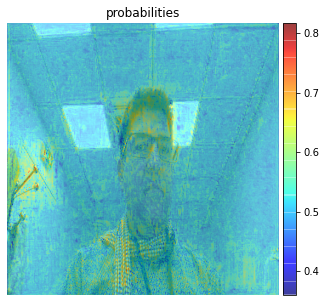

In [33]:
if image.max() < 100:
    vmax = 1
mask_proba = np.ma.masked_where(proba < 0.001, proba)
fig = plt.figure(figsize=(30,5))
n = proba.shape[1]
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.imshow(image, vmin=0, vmax=vmax)
    plt.imshow(mask_proba[0,i,:,:].squeeze(), cmap='jet', alpha=0.5) # interpolation='none'
    plt.axis('off')
if n > 1:
    plt.title("class " + str(i))
else:
    plt.title('probabilities')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)